In [6]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import math


# Number of qubits
num_qubits = 5

# Initialize the device
dev = qml.device("lightning.qubit", wires=num_qubits)

In [7]:
# Construct the Hamiltonian terms
Hamiltonian_terms = []

# Interaction terms: XiX(i+1) + YiY(i+1) + ZiZ(i+1)
for i in range(num_qubits):
    Hamiltonian_terms.append(1.0 * (qml.PauliX(i) @ qml.PauliX((i+1)%num_qubits)) +
                                    (qml.PauliY(i) @ qml.PauliY((i+1)%num_qubits)) 
                                    + (qml.PauliZ(i) @ qml.PauliZ((i+1)%num_qubits)))

# Magnetic field terms: hZi
for i in range(num_qubits):
    Hamiltonian_terms.append(1.0 * qml.PauliZ(i))

# Define the Hamiltonian
Hamiltonian_operator = qml.Hamiltonian(coeffs=[1] * len(Hamiltonian_terms), observables=Hamiltonian_terms)
print(Hamiltonian_operator.eigvals())

[-8.47213595 -8.47213595 -6.47213595 -6.47213595 -5.23606798 -5.23606798
 -4.         -3.23606798 -3.23606798 -2.         -1.23606798 -1.23606798
 -0.76393202 -0.76393202  0.          0.47213595  0.47213595  0.76393202
  0.76393202  1.23606798  1.23606798  2.          2.47213595  2.47213595
  3.23606798  3.23606798  4.          5.23606798  5.23606798  6.
  8.         10.        ]


In [8]:

# Original rotosolve
gates = [qml.RX, qml.RY, qml.RZ]

def entangling_layer(num_qubits):
    # create ladder controlled-Z layer
    # create ladder controlled-Z layer
    m=0
    n=1
    while m+1 < num_qubits:
        qml.CZ(wires=[m,m+1])
        m+=2

    while n+1 < num_qubits:
        qml.CZ(wires=[n,n+1])
        n+=2


# Define the quantum circuit
def circuit_roto(params, layers):
    
    for j in range(layers):
        # Assign all single qubit gates and thetas for all layers

        for k in range(num_qubits):
            qml.RX(params[k + 2 * num_qubits * j], wires = k)

        for n in range(num_qubits):
            qml.RY(params[(n + num_qubits) + 2 * num_qubits * j], wires = n)    

        
        entangling_layer(num_qubits)


# Define the cost function
@qml.qnode(dev)
def cost_roto(params, layers):
    circuit_roto(params, layers)
    return qml.expval(Hamiltonian_operator)


def opt_theta(d, params, cost, layers):
    params[d] = 0.0
    M_0 = cost(params, layers)
    params[d] = np.pi / 2.0
    M_0_plus = cost(params, layers)
    params[d] = -np.pi / 2.0
    M_0_minus = cost(params, layers)
    a = np.arctan2(
        2.0 * M_0 - M_0_plus - M_0_minus, M_0_plus - M_0_minus
    )  # returns value in (-pi,pi]
    params[d] = -np.pi / 2.0 - a
    # restrict output to lie in (-pi,pi], a convention
    # consistent with the Rotosolve paper
    if params[d] <= -np.pi:
        params[d] += 2 * np.pi


def abs_diff(theta1, theta2):
    # direct difference
    diff = abs(theta1 - theta2)
    # wrap-around difference
    wrap = 2 * math.pi - diff
    # shortest distance
    return min(diff, wrap)

# one cycle of rotosolve
def rotosolve_cycle(cost, params, layers, energy_vals, freeze_thres, freeze_counters, freeze_iters_k, gate_opts, gate_opts_tresh):
    for d in range(len(params)):

        if freeze_counters[d] > 0:
            freeze_counters[d] = freeze_counters[d] - 1
            continue
        
        prev_theta = params[d].copy()

        energy_vals.append(cost(params,  layers))
        opt_theta(d, params, cost, layers)

        new_theta = params[d].copy()

        
        diff = abs_diff(prev_theta, new_theta)
        
        if diff < freeze_thres:
            freeze_counters[d] = freeze_iters_k
            #print(f"freeze gate {d}")

        gate_opts += 1
        
        if gate_opts > gate_opts_tresh:
            print("gate opt thres reached")
            break
        
    return params, energy_vals, gate_opts



In [10]:

layers = [3,5]
n_steps = 100
trials = 20

freeze_iters_k_list = [5,15]

dvals = [0.01,0.005, 0.001]

for d in dvals:
    freeze_thres =  d

    print(freeze_thres)

    for freeze_iters_k in freeze_iters_k_list:
        for layer in layers:
            for j in range(trials):
                print("trial: ", j+1)
                layer_vals_roto = []
                params_rsol = np.random.uniform(-np.pi, np.pi, 2*num_qubits*layer, requires_grad=True)
                    
                energy_vals = []
                param_vals = []

                freeze_counters = np.zeros(len(params_rsol))

                gate_opts_tresh = 2 * num_qubits * layer * n_steps 
                gate_opts = 0

                while True:
                    
                    if gate_opts > gate_opts_tresh:
                
                        break

                    params_rsol, energy_vals, gate_opts = rotosolve_cycle(cost=cost_roto, 
                                                                            params=params_rsol, 
                                                                            layers=layer, 
                                                                            energy_vals=energy_vals, 
                                                                            freeze_thres=freeze_thres, 
                                                                            freeze_counters = freeze_counters,
                                                                            freeze_iters_k = freeze_iters_k,
                                                                            gate_opts = gate_opts, 
                                                                            gate_opts_tresh = gate_opts_tresh
                                                                            )

                
                file = f"1DHeisenberg_{num_qubits}Q_rotosolve_GateFreeze_d{d}_FreezeIters{freeze_iters_k}_{n_steps}cycles_{layer}layers_{trials}trials.xlsx"
                
                if not os.path.exists(file):
                    df = pd.DataFrame()
                    df.to_excel(file)

                df = pd.read_excel(file)
                
                if len(df.columns) < trials:
                    df[f"col{len(df.columns)}"] = pd.Series(energy_vals)
                    df.to_excel(file,index = False)
                    
                else:
                    break
                


    

0.01
trial:  1
gate opt thres reached
trial:  2
gate opt thres reached
trial:  3
gate opt thres reached
trial:  4
gate opt thres reached
trial:  5
gate opt thres reached
trial:  6
gate opt thres reached
trial:  7
gate opt thres reached
trial:  8
gate opt thres reached
trial:  1
gate opt thres reached
trial:  2
gate opt thres reached
trial:  3
gate opt thres reached
trial:  4
gate opt thres reached
trial:  5
gate opt thres reached
trial:  6
gate opt thres reached
trial:  7
gate opt thres reached
trial:  8
gate opt thres reached
trial:  9
gate opt thres reached
trial:  10
gate opt thres reached
trial:  1
gate opt thres reached
trial:  2
gate opt thres reached
trial:  3
gate opt thres reached
trial:  4
gate opt thres reached
trial:  5
gate opt thres reached
trial:  6
gate opt thres reached
trial:  7
gate opt thres reached
trial:  8
gate opt thres reached
trial:  9
gate opt thres reached
trial:  10
gate opt thres reached
trial:  1
gate opt thres reached
trial:  2
gate opt thres reached
tri

C:\Users\joonp\AppData\Local\Temp\ipykernel_6708\740691655.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


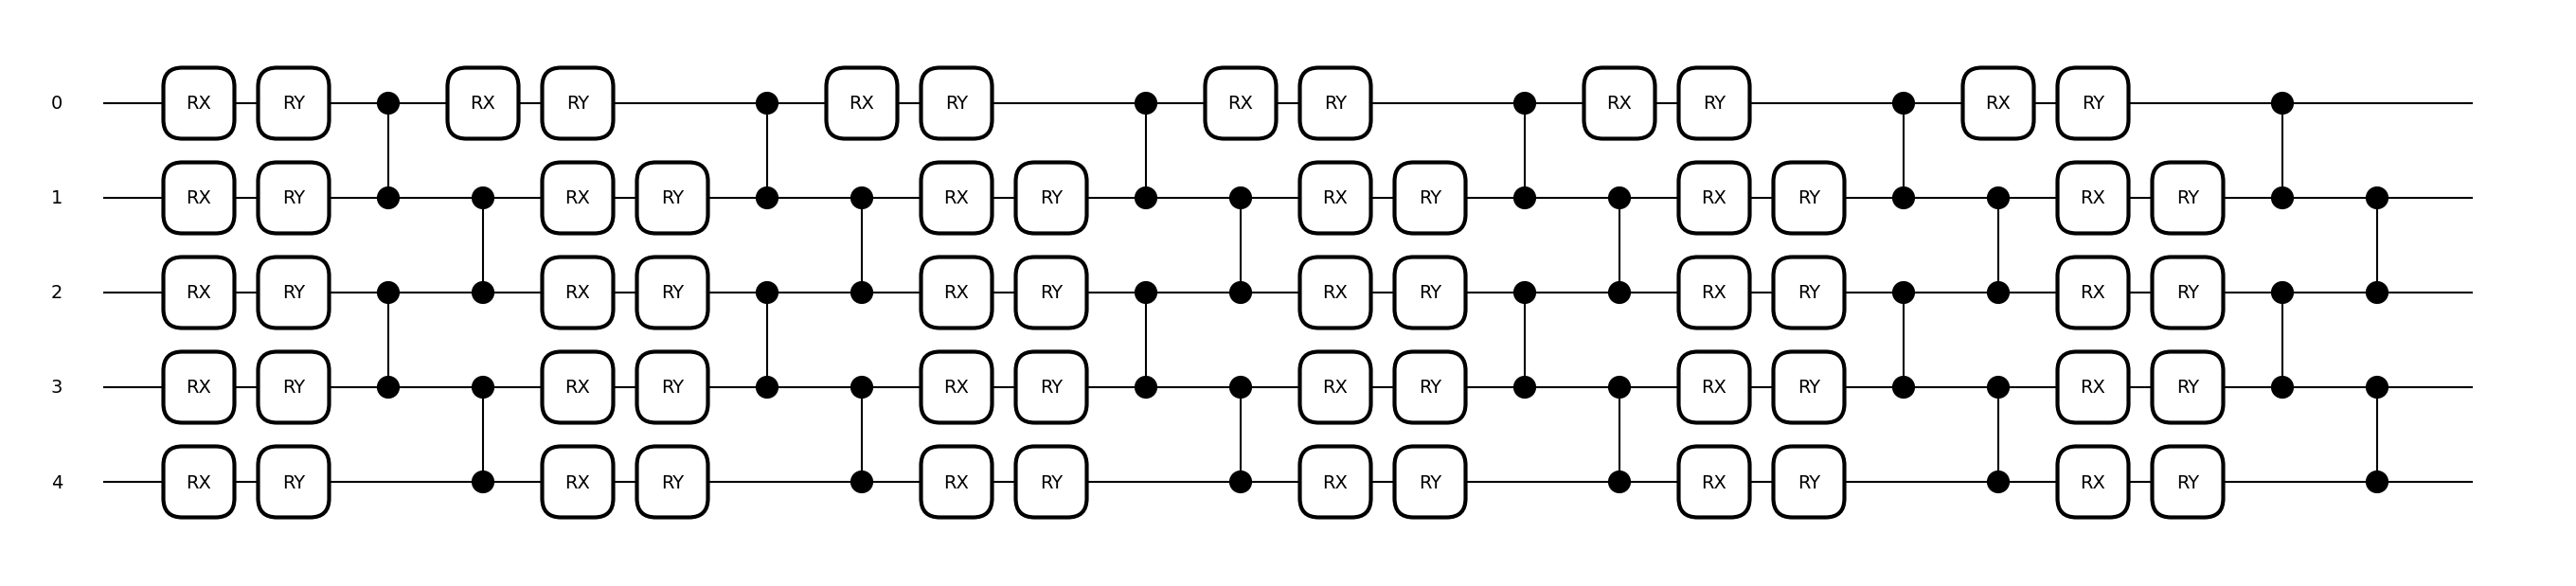

In [ ]:
fig, ax = qml.draw_mpl(circuit_roto)(params_rsol,  layer)
fig.show()